In [1]:
import numpy as np
from rdkit import Chem
from IPython import display
import urllib.request 
import pandas as pd
from rdkit.Chem import AllChem, Draw, Descriptors, PandasTools
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn import preprocessing
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

url = 'https://raw.githubusercontent.com/onecoinbuybus/Database_chemoinformatics/master/platinum_dataset.csv'
urllib.request.urlretrieve(url, 'platinum_dataset.csv') 
df = pd.read_csv('platinum_dataset.csv', index_col=0) 

mols=[]
for i in df['smiles']:
    mols.append(Chem.MolFromSmiles(i))

In [67]:
def unhash(mols,radius):
    values=[]
    bit_info=[]
    for mol in mols:
        ECFP_bitinfo = {}
        mfp = AllChem.GetMorganFingerprint(mol, radius, bitInfo=ECFP_bitinfo, useFeatures=False)
        mfp_info = mfp.GetNonzeroElements()
        values.append(mfp.GetNonzeroElements())
        bit_info.append(ECFP_bitinfo)
    df_mfp = pd.DataFrame.from_dict(values)
    df_mfp.fillna(0., inplace=True)
    return df_mfp,bit_info

unhashed_fp, bit_info=unhash(mols, 1)
unhashed_fp.head()

,74537039,98513984,847961216,864942730,864942795,951226070,1362518133,1506563592,1506993418,1510323402,...,3523875182,2231827287,2248888332,4210236161,2687568853,2580639636,3294021736,188565530,4268263804,3774303344
0,1.0,3.0,3.0,4.0,2.0,2.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,3.0,0.0,2.0,0.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,3.0,1.0,3.0,0.0,6.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
unhashed_fp.shape

(4548, 2700)

In [4]:
molwt = [Descriptors.MolWt(x) for x in mols]

In [68]:
clf = RandomForestRegressor()
clf.fit(unhashed_fp, molwt)

RandomForestRegressor()

In [72]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, unhashed_fp, molwt)
print(scores)

[0.86812279 0.88671874 0.87943834 0.88031402 0.87118569]


In [69]:
feat_imp = pd.DataFrame({'id': unhashed_fp.columns,'imp': clf.feature_importances_})
feat_imp = feat_imp.sort_values(by='imp', ascending=False)
feat_imp

,id,imp
22,3217380708,0.285893
3,864942730,0.164389
95,2976033787,0.124828
23,3218693969,0.055606
13,2245384272,0.044275
...,...,...
2447,1473573141,0.000000
1776,4170800875,0.000000
2459,1081516635,0.000000
147,3877310530,0.000000


In [75]:
unhashed_fp[3217380708][:10]

0    1.0
1    9.0
2    9.0
3    3.0
4    4.0
5    8.0
6    4.0
7    7.0
8    1.0
9    6.0
Name: 3217380708, dtype: float64

In [80]:
# from rdkit.Chem.Draw import DrawMorganBit, DrawMorganBits,DrawMorganEnv, IPythonConsole
# ECFP_bitinfo = {}
# ECFP = AllChem.GetMorganFingerprint(mols[1], radius=1, bitInfo=ECFP_bitinfo, useFeatures=False)
# ECFP_tuples = [(mols[1], bit, ECFP_bitinfo) for bit in list(ECFP_bitinfo.keys())]
# DrawMorganBits(ECFP_tuples, molsPerRow=3, legends=list(map(str, list(ECFP_bitinfo.keys()))))

In [81]:
x = unhashed_fp[unhashed_fp.columns[unhashed_fp.columns != 3217380708]]

In [84]:
x_0 = x[unhashed_fp[3217380708] == 0.0]
x_1 = x[unhashed_fp[3217380708] != 0.0]

In [87]:
molwt_0 = np.array(molwt)[x_0.index]
molwt_1 = np.array(molwt)[x_1.index]

In [89]:
reg_0 = RandomForestRegressor()
reg_0.fit(x_0, molwt_0)

reg_1 = RandomForestRegressor()
reg_1.fit(x_1, molwt_1)

RandomForestRegressor()

In [90]:
#ATE calculation
mu_0 = reg_0.predict(x)
mu_1 = reg_1.predict(x)

ATE = (mu_1-mu_0).mean()
print("ATE：", ATE)

ATE： 141.46519388742314


In [91]:
ATT = molwt_1 - reg_0.predict(x_1)
ATU = reg_1.predict(x_0) - molwt_0

print("ATT：", ATT.mean())
print("ATU：", ATU.mean())

ATT： 153.89859624232008
ATU： 49.36334588726516


In [92]:
t_estimated = reg_1.predict(x) - reg_0.predict(x)

In [95]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(unhashed_fp)
unhashed_fp_reduced = pca.fit_transform(unhashed_fp)

No handles with labels found to put in legend.


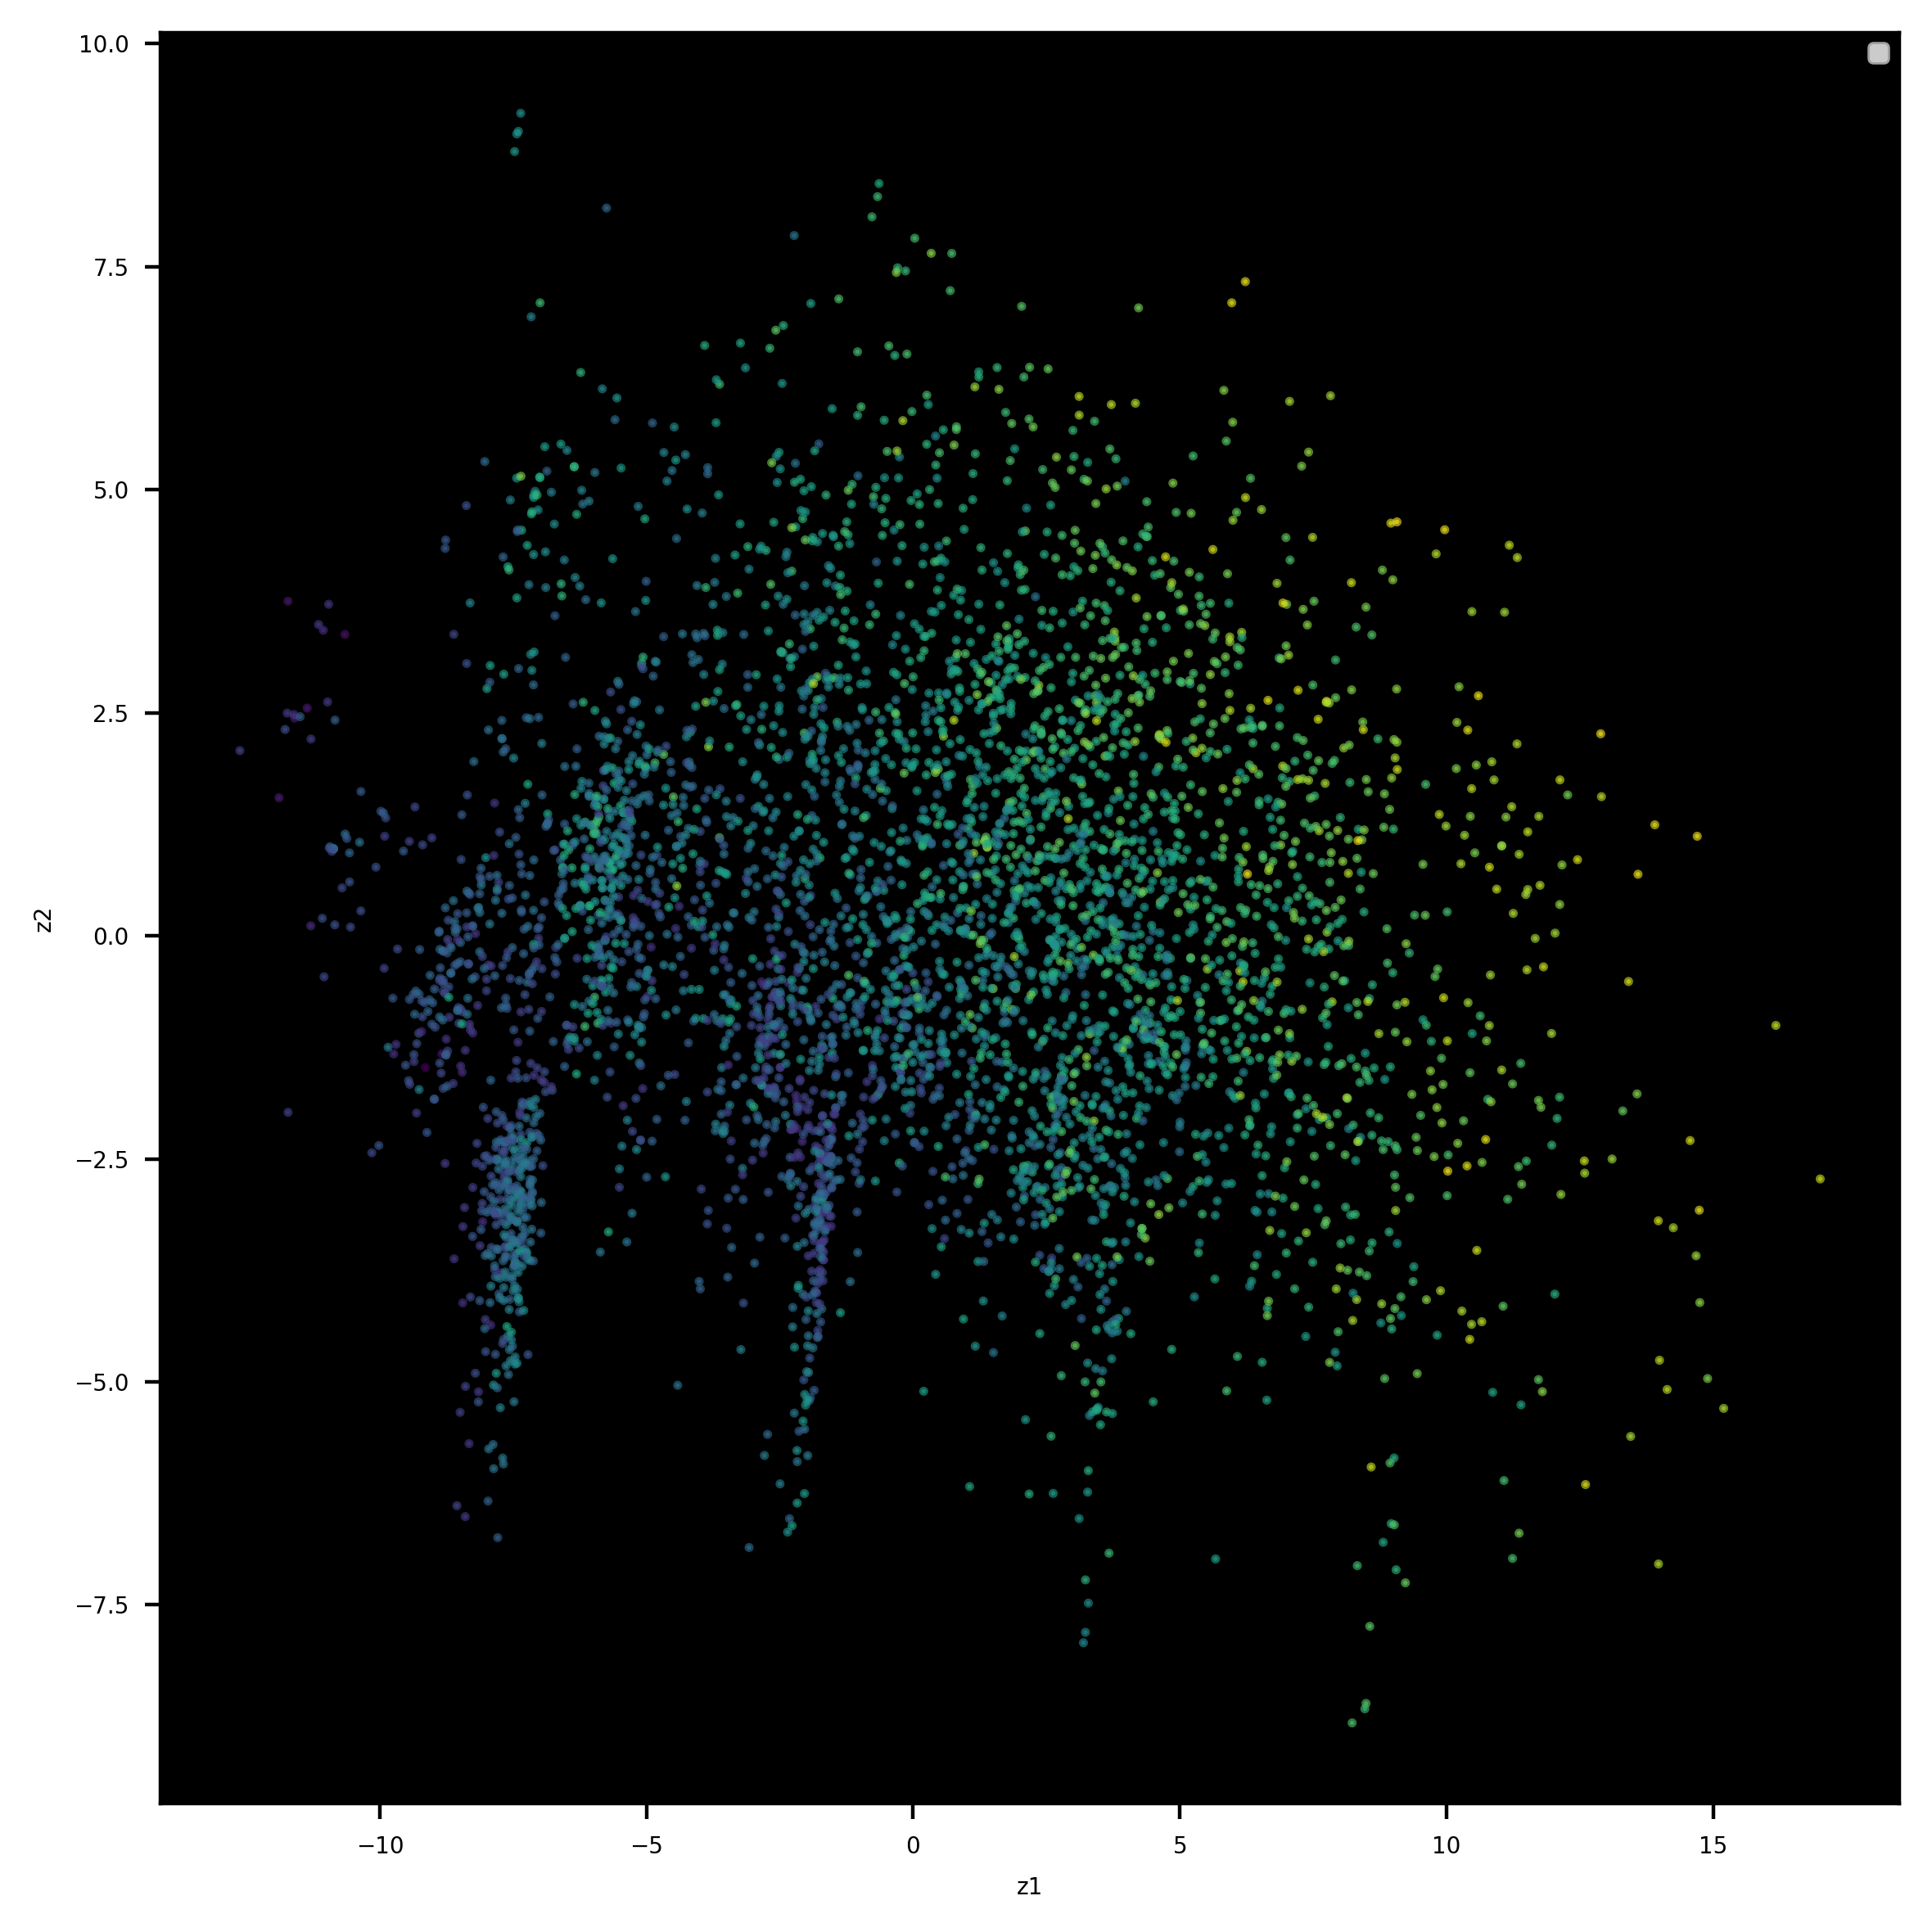

In [103]:


%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm 

plt.figure(figsize=(6,6),dpi=400)
plt.scatter(unhashed_fp_reduced[:, 0],
            unhashed_fp_reduced[:, 1], 
            alpha = 0.6, 
            s=1,c = t_estimated)
     
plt.xlabel("z1", fontsize=5)
plt.ylabel("z2", fontsize=5)
plt.tick_params(labelsize=5)
plt.legend(fontsize=5)
plt.tight_layout()
ax = plt.gca()
ax.set_facecolor('black')
plt.show()

In [104]:
#S-learner
clf = RandomForestRegressor()
clf.fit(unhashed_fp, molwt)

RandomForestRegressor()

In [105]:
X_0 = unhashed_fp.copy()
X_0[3217380708] = 0.0

X_1 = unhashed_fp.copy()
X_1[3217380708] = 1.0

In [108]:
ATE = (clf.predict(X_1)-clf.predict(X_0)).mean()
print("ATE：", ATE)

ATE： 2.713651840369393


In [109]:
# X-learner
M0 = RandomForestRegressor()
M0.fit(x_0, molwt_0)

M1 = RandomForestRegressor()
M1.fit(x_0, molwt_0)
tau_0 = reg_1.predict(x_0) - molwt_0
tau_1 = molwt_1 - reg_0.predict(x_1)

RandomForestRegressor()

In [111]:
M2 = RandomForestRegressor()
M2.fit(x_0, tau_0)

M3 = RandomForestRegressor()
M3.fit(x_1, tau_1)

RandomForestRegressor()

In [115]:
from sklearn.linear_model import LogisticRegression
z = unhashed_fp[3217380708]

g_x = LogisticRegression().fit(x, z)
g_x_val = g_x.predict_proba(x)

tau = g_x_val[:, 1]*M2.predict(x) + g_x_val[:, 0]*M3.predict(x)

/Users/yweilin/opt/anaconda3/envs/myenv1/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


No handles with labels found to put in legend.


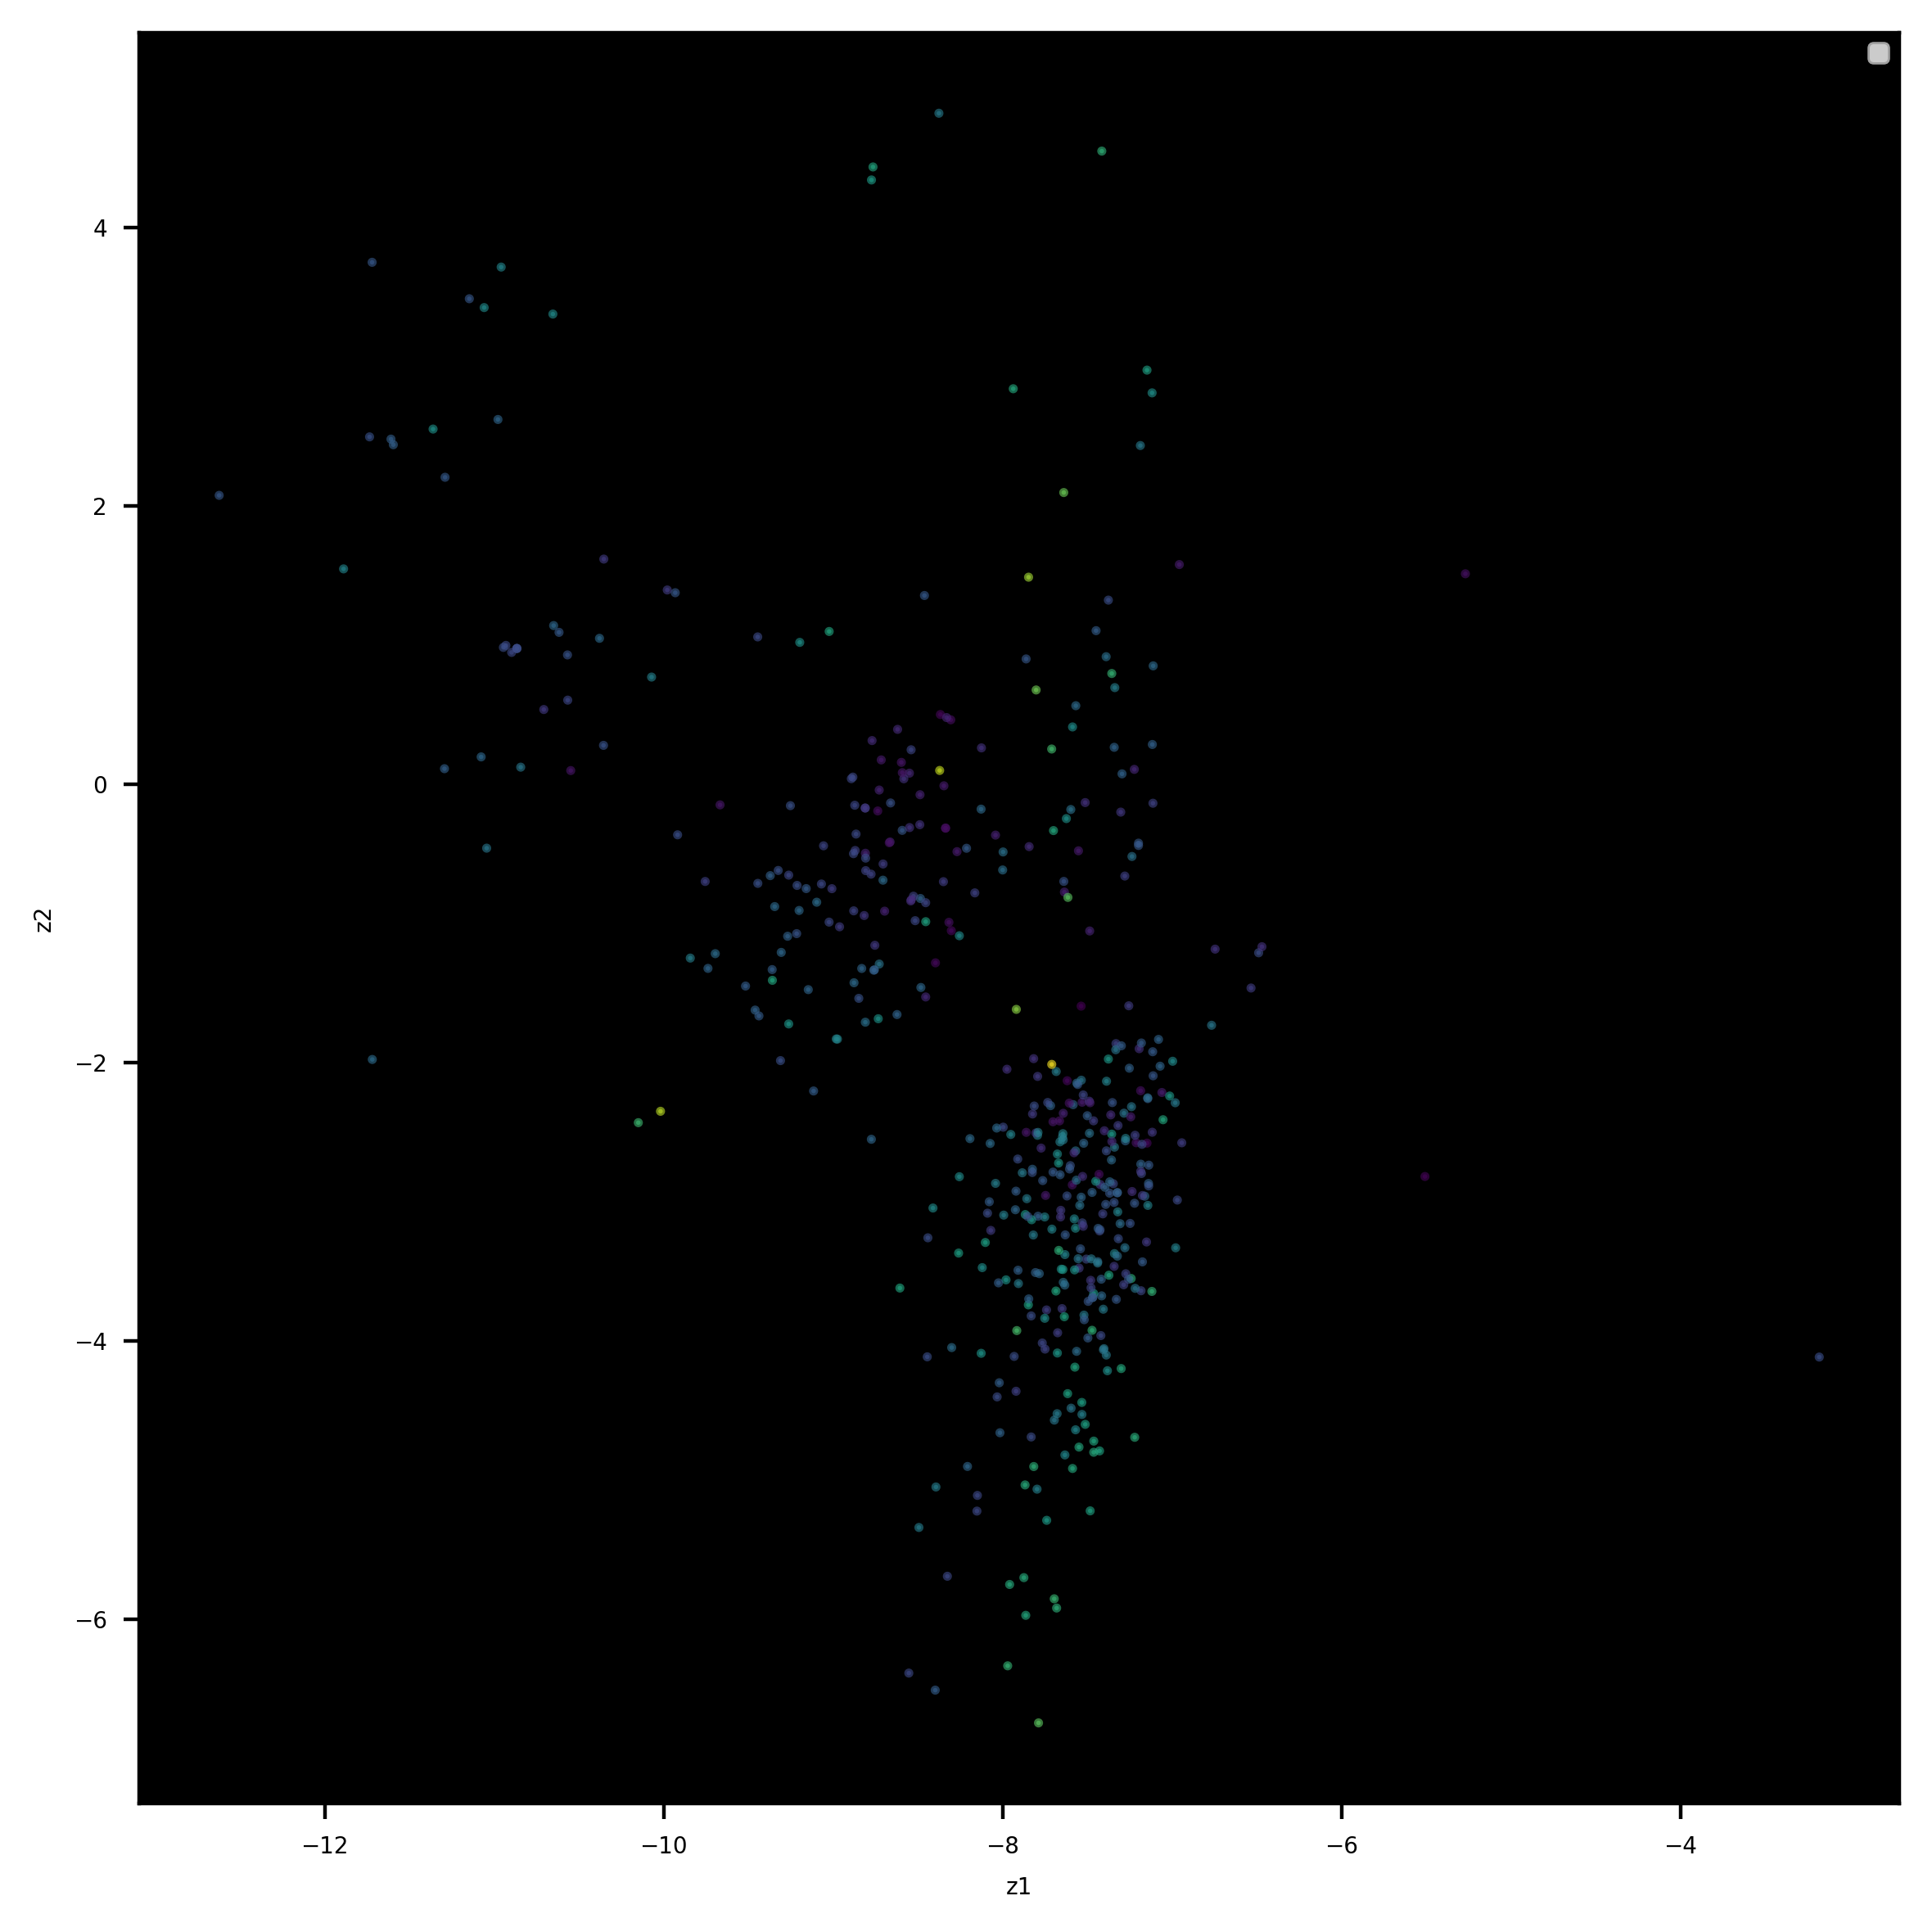

In [119]:
plt.figure(figsize=(6,6),dpi=400)
plt.scatter(unhashed_fp_reduced[:, 0][unhashed_fp[3217380708] == 0.0],
            unhashed_fp_reduced[:, 1][unhashed_fp[3217380708] == 0.0], 
            alpha = 0.6, 
            s=1,c = tau[unhashed_fp[3217380708] == 0.0])
     
plt.xlabel("z1", fontsize=5)
plt.ylabel("z2", fontsize=5)
plt.tick_params(labelsize=5)
plt.legend(fontsize=5)
plt.tight_layout()
ax = plt.gca()
ax.set_facecolor('black')
plt.show()

In [120]:
feat_t = pd.DataFrame({'smiles': df['smiles'],'t': t_estimated})
feat_t.sort_values(by='t')

,smiles,t
3425,O=S(=O)([O-])OC(C(O)C[S+]1CC(O)C(O)C1CO)C(O)C(...,-91.02149
2612,C[NH2+]C1C(O)C(OC2C([NH3+])CC([NH3+])C(OC3OC(C...,-70.73901
1824,CNC1C(OC2OC(CO)C([NH3+])C(O)C2O)OC2CC([NH3+])C...,-64.71453
3239,OCC1OC(OC2C(CO)OC(OCCCCCCC3CCCCC3)C(O)C2O)C(O)...,-57.02200
2795,C[NH2+]C1CC([NH3+])C(O)C(OC2OC(CO)C(O)C3OC4(OC...,-55.64584
...,...,...
1456,Nc1noc2ccc(-n3nc(C(F)(F)F)c4c3C(=O)N(c3ccc(-c5...,365.10949
1055,CNc1ncc2c(F)c(-c3c(C)ccc(C(=O)c4c(-c5ccccc5)n(...,365.39308
2304,CCC(CC)(c1ccc(/C=C/C(O)(C(F)(F)F)C(F)(F)F)c(C)...,366.26648
3069,Cc1ccc(C(=O)Nc2ccc(Oc3cc4cnn(C)c4cc3-c3cn[nH]c...,369.03547


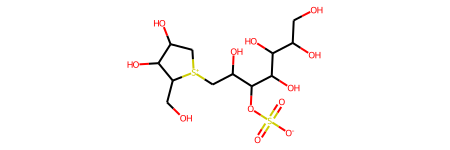

In [121]:
mols[3425]

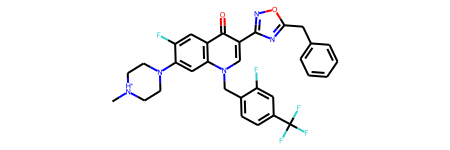

In [122]:
mols[3035]